# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_3-filterv2:oracle.run1.framed -> cores",
    "device": "cuda",
    "lr": 0.0001,
    "x_shape": [2, 200],
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 16000, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag", "lowpass_+/-10MHz", "take_200"],
            "episode_transforms": [],
            "domain_prefix": "C_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag", "take_200", "resample_20Msps_to_25Msps"],
            "episode_transforms": [],
            "domain_prefix": "O_",
        },
    ],
    "seed": 1337,
    "dataset_seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'O_44', 'O_14', 'O_38', 'O_20', 'O_26', 'O_32', 'O_8', 'O_50'}


{'C_3', 'C_4', 'C_2', 'C_1', 'C_5'}


tensor([[[-0.0971,  1.1311,  0.6428,  ...,  0.6900,  0.5495,  0.7515],
         [-0.6699, -0.6023,  0.7298,  ..., -0.1188,  1.1722,  0.1223]],

        [[-0.4650,  0.4729,  0.8381,  ...,  1.1898,  0.5315,  0.0195],
         [-1.1721, -0.8223,  0.9095,  ..., -0.4716, -0.6551, -1.4318]],

        [[ 0.6704, -0.0551, -0.9197,  ..., -0.8651, -0.9602, -0.1043],
         [ 0.8524,  1.1014, -0.5470,  ...,  0.4879,  0.2662,  1.2135]],

        ...,

        [[ 1.0094,  0.2418, -1.2327,  ..., -0.7204, -0.1579,  0.9442],
         [ 0.5694,  0.9394, -0.0507,  ...,  1.0085,  0.7567,  1.0278]],

        [[ 0.0259, -1.0459, -0.2935,  ..., -0.8818, -0.8675, -0.9829],
         [ 0.8104,  0.8015, -0.7676,  ..., -0.1278, -0.7103,  0.6759]],

        [[ 0.4981,  0.4795, -0.3590,  ...,  0.5028, -1.2225, -0.6749],
         [-0.4260,  0.9681,  0.7596,  ...,  0.6907,  0.2936,  0.4766]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 200)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 47.0937, train_label_loss: 2.9630, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 1974.1858, train_label_loss: 1.0335, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 1968.9487, train_label_loss: 0.7765, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 1972.7614, train_label_loss: 0.7099, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2065.7051, train_label_loss: 1.1289, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2647.2953, train_label_loss: 1.0327, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2009.3830, train_label_loss: 0.9185, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 1969.8232, train_label_loss: 0.6402, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 1975.4902, train_label_loss: 0.8687, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 1979.7937, train_label_loss: 0.5362, 


epoch: 1, source_val_acc_label: 0.5761, target_val_acc_label: 0.5986, source_val_label_loss: 51.1800, target_val_label_loss: 1836.6936, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.8479, train_label_loss: 91.5329, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 1986.8205, train_label_loss: 0.7966, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 1983.8599, train_label_loss: 0.5969, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 1983.3689, train_label_loss: 1.3707, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2132.5243, train_label_loss: 0.9669, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2714.4722, train_label_loss: 0.6532, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 1984.4757, train_label_loss: 0.6084, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 1979.3861, train_label_loss: 0.8858, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 1983.0700, train_label_loss: 1.1341, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 1986.4213, train_label_loss: 0.5739, 


epoch: 2, source_val_acc_label: 0.7479, target_val_acc_label: 0.6716, source_val_label_loss: 0.6986, target_val_label_loss: 110.6557, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.8572, train_label_loss: 0.8494, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 1985.6676, train_label_loss: 0.3557, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 1985.7762, train_label_loss: 0.5819, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 1982.7352, train_label_loss: 0.4883, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2147.1155, train_label_loss: 0.5764, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2723.3453, train_label_loss: 0.8772, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 1982.9906, train_label_loss: 0.7952, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 1978.6624, train_label_loss: 0.5392, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 1982.9602, train_label_loss: 0.3936, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 1987.1848, train_label_loss: 0.2572, 


epoch: 3, source_val_acc_label: 0.7391, target_val_acc_label: 0.6730, source_val_label_loss: 0.7039, target_val_label_loss: 131.3973, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.8708, train_label_loss: 0.3773, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 1984.4687, train_label_loss: 0.2579, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 1981.1325, train_label_loss: 1.0227, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 1982.0601, train_label_loss: 0.8492, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2129.2862, train_label_loss: 0.5666, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2686.7698, train_label_loss: 0.3513, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 1966.5601, train_label_loss: 0.8774, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 1962.7402, train_label_loss: 0.4481, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 1969.1690, train_label_loss: 0.7383, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 1969.9290, train_label_loss: 0.3040, 


epoch: 4, source_val_acc_label: 0.7783, target_val_acc_label: 0.6871, source_val_label_loss: 0.6043, target_val_label_loss: 135.5280, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.8612, train_label_loss: 0.2868, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 1969.7847, train_label_loss: 0.4429, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 1968.9535, train_label_loss: 0.6909, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 1967.1799, train_label_loss: 0.9389, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2125.9700, train_label_loss: 0.5884, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2648.4959, train_label_loss: 0.2432, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 1994.7205, train_label_loss: 0.3182, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 1978.2350, train_label_loss: 0.1790, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 1981.0974, train_label_loss: 0.7279, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 1984.8330, train_label_loss: 0.3287, 


epoch: 5, source_val_acc_label: 0.8249, target_val_acc_label: 0.6882, source_val_label_loss: 0.4799, target_val_label_loss: 127.4151, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.8620, train_label_loss: 0.5003, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 1980.7613, train_label_loss: 0.7401, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 1981.8758, train_label_loss: 0.7145, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 1977.9473, train_label_loss: 0.3588, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2129.4317, train_label_loss: 0.1134, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2701.7064, train_label_loss: 0.1774, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 1983.1703, train_label_loss: 0.5201, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 1976.5477, train_label_loss: 0.5260, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 1981.7749, train_label_loss: 0.3104, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 1985.7960, train_label_loss: 0.1983, 


epoch: 6, source_val_acc_label: 0.8306, target_val_acc_label: 0.7117, source_val_label_loss: 0.4611, target_val_label_loss: 120.4501, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.8790, train_label_loss: 0.1747, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 1985.4806, train_label_loss: 0.7750, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 1982.6842, train_label_loss: 0.2693, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 1981.5783, train_label_loss: 0.6339, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2137.3806, train_label_loss: 0.4033, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2722.6603, train_label_loss: 0.8388, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 1981.4474, train_label_loss: 0.1781, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 1978.1818, train_label_loss: 0.4863, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 1980.0544, train_label_loss: 0.2351, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 1987.2990, train_label_loss: 0.2345, 


epoch: 7, source_val_acc_label: 0.8389, target_val_acc_label: 0.7189, source_val_label_loss: 0.4420, target_val_label_loss: 118.0395, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.8641, train_label_loss: 0.6787, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 1982.8210, train_label_loss: 0.5983, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 1982.7816, train_label_loss: 0.5048, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 1981.1579, train_label_loss: 0.1736, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2142.7155, train_label_loss: 0.1932, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2715.6323, train_label_loss: 0.4775, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 1977.3197, train_label_loss: 0.5126, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 1977.1967, train_label_loss: 0.2383, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 1980.6964, train_label_loss: 0.3878, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 1984.3792, train_label_loss: 0.3869, 


epoch: 8, source_val_acc_label: 0.8562, target_val_acc_label: 0.7267, source_val_label_loss: 0.3899, target_val_label_loss: 120.5062, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.8626, train_label_loss: 0.1662, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 1985.2702, train_label_loss: 0.6856, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 1982.0449, train_label_loss: 0.4365, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 1983.6731, train_label_loss: 0.2777, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2145.8178, train_label_loss: 0.1879, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2718.0726, train_label_loss: 0.6059, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 1978.4942, train_label_loss: 0.8822, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 1978.6796, train_label_loss: 0.2703, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 1981.4322, train_label_loss: 0.1414, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 1986.0385, train_label_loss: 0.2851, 


epoch: 9, source_val_acc_label: 0.8623, target_val_acc_label: 0.7212, source_val_label_loss: 0.3785, target_val_label_loss: 122.7738, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.8560, train_label_loss: 0.4957, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 1983.4323, train_label_loss: 0.2075, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 1983.4427, train_label_loss: 0.3816, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 1983.0009, train_label_loss: 0.0303, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2147.5544, train_label_loss: 0.4594, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2696.2871, train_label_loss: 0.0982, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 1983.3028, train_label_loss: 0.4594, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 1977.9197, train_label_loss: 0.6751, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 1978.7438, train_label_loss: 0.5027, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 1985.0767, train_label_loss: 0.1561, 


epoch: 10, source_val_acc_label: 0.8752, target_val_acc_label: 0.7229, source_val_label_loss: 0.3447, target_val_label_loss: 103.9793, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.8998, train_label_loss: 0.3126, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 1984.1832, train_label_loss: 0.3832, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 1984.6992, train_label_loss: 0.5324, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 1981.5561, train_label_loss: 0.0461, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2140.7724, train_label_loss: 0.7126, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2677.3672, train_label_loss: 0.3107, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 1982.9122, train_label_loss: 0.1090, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 1978.1552, train_label_loss: 0.1618, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 1981.8524, train_label_loss: 0.1654, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 1986.7956, train_label_loss: 0.1721, 


epoch: 11, source_val_acc_label: 0.8725, target_val_acc_label: 0.7337, source_val_label_loss: 0.3453, target_val_label_loss: 109.8058, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.8798, train_label_loss: 0.6991, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 1985.4223, train_label_loss: 0.4208, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 1979.6194, train_label_loss: 0.0978, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 1981.6479, train_label_loss: 0.6091, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2142.0995, train_label_loss: 0.2001, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2701.3909, train_label_loss: 0.3482, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 1979.6438, train_label_loss: 0.2765, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 1980.6811, train_label_loss: 0.0978, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 1982.9204, train_label_loss: 0.1218, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 1985.7692, train_label_loss: 0.0544, 


epoch: 12, source_val_acc_label: 0.8780, target_val_acc_label: 0.7460, source_val_label_loss: 0.3416, target_val_label_loss: 120.0291, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.8577, train_label_loss: 0.3855, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 1985.2910, train_label_loss: 0.2182, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 1982.3005, train_label_loss: 0.0995, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 1982.7784, train_label_loss: 0.1516, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2142.6685, train_label_loss: 0.0891, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2728.4373, train_label_loss: 0.1202, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 1982.5721, train_label_loss: 0.4312, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 1977.9158, train_label_loss: 0.0437, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 1980.9112, train_label_loss: 0.1116, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 1986.0569, train_label_loss: 0.2553, 


epoch: 13, source_val_acc_label: 0.8646, target_val_acc_label: 0.7527, source_val_label_loss: 0.3816, target_val_label_loss: 134.1837, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.8873, train_label_loss: 0.3891, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 1985.3971, train_label_loss: 0.2020, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 1982.5610, train_label_loss: 0.3771, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 1980.4375, train_label_loss: 0.1893, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 2135.2845, train_label_loss: 0.0804, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2676.7732, train_label_loss: 0.1403, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 1981.8099, train_label_loss: 0.4648, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 1978.4886, train_label_loss: 0.1286, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 1980.4429, train_label_loss: 0.0812, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 1985.7598, train_label_loss: 0.1174, 


epoch: 14, source_val_acc_label: 0.8742, target_val_acc_label: 0.7352, source_val_label_loss: 0.3506, target_val_label_loss: 128.0303, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.8856, train_label_loss: 0.0320, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 1984.8670, train_label_loss: 0.1187, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 1980.9833, train_label_loss: 0.0389, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 1982.6551, train_label_loss: 0.0842, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2141.5065, train_label_loss: 0.1771, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2742.5707, train_label_loss: 0.2240, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 1984.4078, train_label_loss: 0.4017, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 1977.9274, train_label_loss: 0.2590, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 1981.9583, train_label_loss: 0.1929, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 1984.1586, train_label_loss: 0.2167, 


epoch: 15, source_val_acc_label: 0.8802, target_val_acc_label: 0.7416, source_val_label_loss: 0.3403, target_val_label_loss: 152.4907, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.8786, train_label_loss: 0.0213, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 1986.3780, train_label_loss: 0.2184, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 1982.7114, train_label_loss: 0.1680, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 1982.0933, train_label_loss: 0.2649, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 2119.7217, train_label_loss: 0.0732, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 2727.2738, train_label_loss: 0.1606, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 1992.8449, train_label_loss: 0.2442, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 1977.8925, train_label_loss: 0.2486, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 1981.7910, train_label_loss: 0.3711, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 1984.3680, train_label_loss: 0.1509, 


epoch: 16, source_val_acc_label: 0.8743, target_val_acc_label: 0.7445, source_val_label_loss: 0.3515, target_val_label_loss: 173.8968, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.8675, train_label_loss: 0.0128, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 1982.0943, train_label_loss: 0.1141, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 1982.0345, train_label_loss: 0.0843, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 1980.7968, train_label_loss: 0.3017, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2130.0191, train_label_loss: 0.1345, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2519.7171, train_label_loss: 0.2361, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2483.3419, train_label_loss: 0.2242, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2448.3594, train_label_loss: 0.0916, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2460.2047, train_label_loss: 0.2096, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 2372.2417, train_label_loss: 0.0498, 


epoch: 17, source_val_acc_label: 0.8805, target_val_acc_label: 0.7443, source_val_label_loss: 0.3418, target_val_label_loss: 171.7509, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

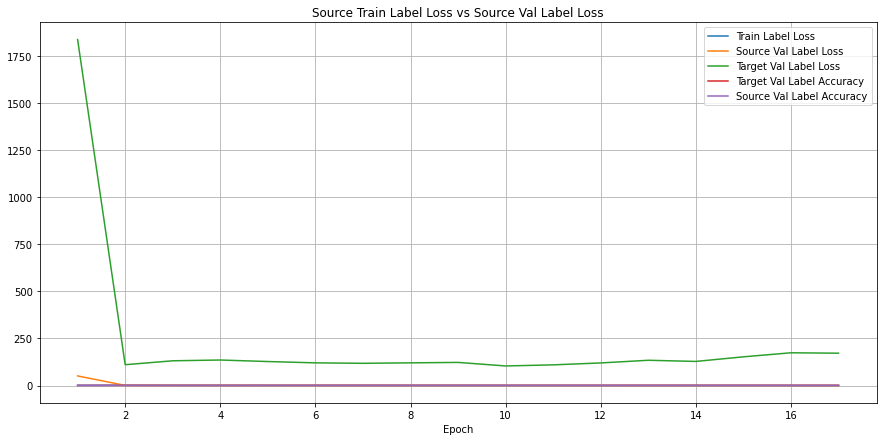

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

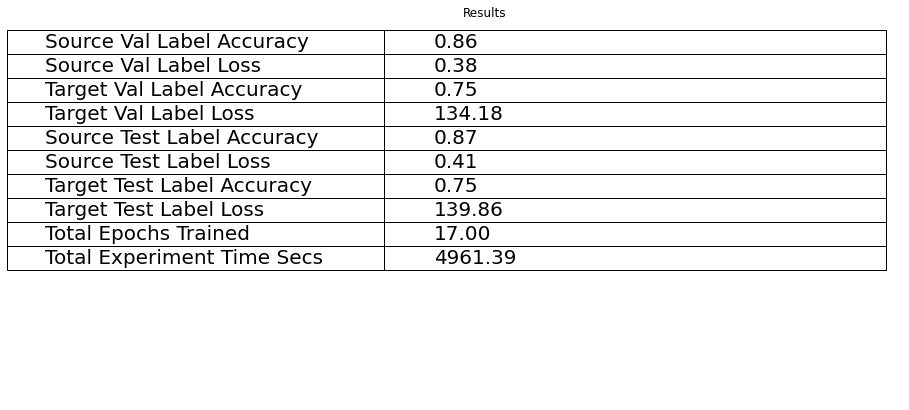

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

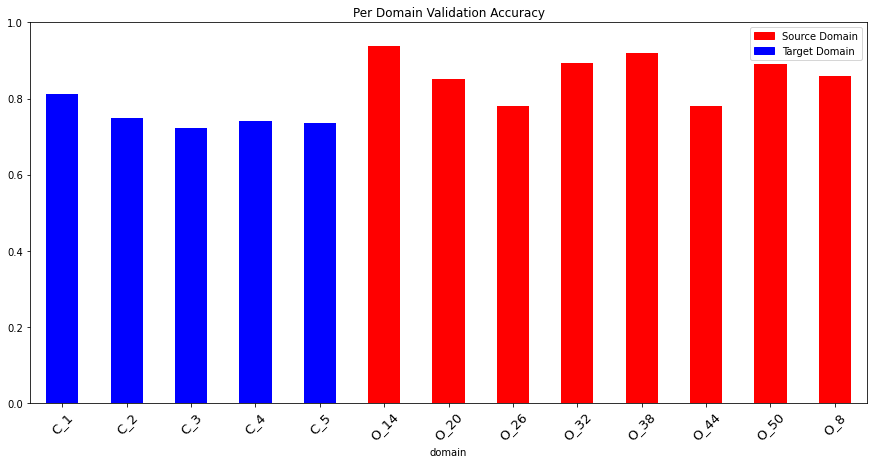

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.8666341145833333 Target Test Label Accuracy: 0.7479657687991021
Source Val Label Accuracy: 0.86455078125 Target Val Label Accuracy: 0.7527468607305936


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_3-filterv2:oracle.run1.framed -> cores", "parameters": {"experiment_name": "tl_3-filterv2:oracle.run1.framed -> cores", "device": "cuda", "lr": 0.0001, "x_shape": [2, 200], "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_